In [133]:
import numpy as np
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import datetime as dt
from sklearn.preprocessing import StandardScaler
import pandas_datareader.data as web
import math
import os
import re
import warnings
import seaborn as sns
warnings.simplefilter('ignore')

In [177]:
def preprocessing(stock):
    
    df = pd.read_excel(f'Tweets/{stock}', header = 0, sheet_name = "Stream")
    for idx, tweet in enumerate(df['Tweet content']):
        df['Tweet content'][idx] = re.sub(r'http\S+', '', tweet)
    date = df['Date']
    time = df['Hour']
    tweet = df['Tweet content']
    followers = df['Followers']
    symbols = df['Symbols']
    new_dict = {'date': date, 'time': time, 'tweet': tweet, 'followers': followers, 'symbols': symbols}
    new_df = pd.DataFrame(new_dict)
    analyzer = SentimentIntensityAnalyzer()


    neg = []
    neu = []
    pos = []
    com = []

    for tweet in new_df['tweet']:
        sentiment = analyzer.polarity_scores(tweet)
        neg.append(sentiment['neg'])
        neu.append(sentiment['neu'])
        pos.append(sentiment['pos'])
        com.append(sentiment['compound'])


    new_df['negative'] = neg
    new_df['neutral'] = neu
    new_df['positive'] = pos
    new_df['compound'] = com

    new_df['followers'].fillna(0, inplace = True)
    new_df['symbols'].fillna('$AAL', inplace = True)
    new_df['Compound_multiplied'] = new_df['compound']*(np.sqrt(new_df['followers']))
    temp = new_df[['Compound_multiplied']].values.astype(float)
    scaled_data = StandardScaler().fit(temp).transform(temp)
    new_df['Compound_multiplied_scaled'] = scaled_data


    df_tweets = new_df[(new_df['date'] <= '2016-06-11') & (new_df['date'] >= '2016-04-01')]

    start = dt.datetime(2016, 4, 1)
    end =  dt.datetime(2016, 6, 11)

    df_stock = web.DataReader(stock.split('.')[0], 'yahoo', start, end)

    df_stock.columns = ['High','Low','Open','Close','Volume_stock','Adj_Close_stock']

    df_stock['HiLo_vola_stock'] = (df_stock['High'] - df_stock['Low']) / df_stock['Adj_Close_stock'] * 100.0
    df_stock['Pct_change_stock'] = (df_stock['Close'] - df_stock['Open']) / df_stock['Open'] * 100.0
    stock_1 = df_stock[['Pct_change_stock']].values.astype(float)
    
    
    scaler = StandardScaler().fit(stock_1)
    scaled_data = scaler.transform(stock_1)
    df_stock['Pct_change_stock_scaled'] = scaled_data

    df_tweets['datetime'] = pd.to_datetime(df_tweets['date'])
    df_tweets.drop(['date'], axis=1, inplace=True)

    df_daily_mean=(df_tweets.groupby(df_tweets.datetime).mean())


    complete_df = pd.concat([df_stock[['Volume_stock','Open','Adj_Close_stock','HiLo_vola_stock','Pct_change_stock', 'Pct_change_stock_scaled']], df_daily_mean], axis=1, sort=False)

    complete_df['Predicted_stock_change'] = complete_df['Pct_change_stock'].shift(-1)
    complete_df[[ "Volume_stock", "Adj_Close_stock", "HiLo_vola_stock", "Pct_change_stock", "Pct_change_stock_scaled", "Open"]] = complete_df[[ "Volume_stock", "Adj_Close_stock", "HiLo_vola_stock", "Pct_change_stock", "Pct_change_stock_scaled", "Open"]].interpolate(method='linear', limit_direction='forward', axis=0)
    buy_sell = []
    count = 0


    for i in complete_df['Predicted_stock_change']:
        if i < 0:
            buy_sell.append(-1)
        else:
            buy_sell.append(1)
    complete_df['Buy/Sell'] = buy_sell     

    complete_df = complete_df[np.isfinite(complete_df['Predicted_stock_change'])]
    complete_df = complete_df[np.isfinite(complete_df['Buy/Sell'])]
    return complete_df

In [178]:
def model(complete_df):
    x = np.array(complete_df[['Compound_multiplied_scaled']])
    y = np.array(complete_df['Buy/Sell'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(x_train, y_train) 
    neigh_cv = cross_val_score(neigh, x_train, y_train, cv=10) 
    
    logreg = LogisticRegression(random_state=42)
    logreg.fit(x_train, y_train)
    logreg_cv = cross_val_score(logreg, x_train, y_train, cv=10)
    
    svm_linear = SVC( kernel = 'linear')
    svm_linear.fit(x_train, y_train)
    svm_linear_cv = cross_val_score(svm_linear, x_train, y_train, cv=10)
    
    scaler = MinMaxScaler() 
    X_minmax = scaler.fit_transform(x_train)
    mnb = MultinomialNB()
    mnb_cv = cross_val_score(mnb, X_minmax, y_train, cv=10)
    
    dtc = tree.DecisionTreeClassifier(random_state=42)
    dtc.fit(x_train, y_train) 
    dtc_cv = cross_val_score(dtc, x_train, y_train, cv=10)
    
    forest_reg = RandomForestClassifier(random_state=42)
    forest_reg.fit(x_train, y_train)
    forest_reg_cv = cross_val_score(forest_reg, x_train, y_train, cv=10) 
      

    Buy_or_Sell_KNN = [] 
    outcome_KNN = (neigh.predict(complete_df[['Compound_multiplied']]))
    complete_df['KNN_prediction'] = outcome_KNN

    Buy_or_Sell_LogReg = []
    outcome_logreg = (logreg.predict(complete_df[['Compound_multiplied']]))
    complete_df['LogReg_prediction'] = outcome_logreg

    Buy_or_Sell_SVM = []
    outcome_svm = (svm_linear.predict(complete_df[['Compound_multiplied']]))
    complete_df['SVM_prediction'] = outcome_svm

    Buy_or_Sell_NB = []
    X_minmax = scaler.fit_transform(complete_df[['Compound_multiplied']])
    Buy_or_Sell = mnb.fit(X_minmax, y)
    outcome_nb = (Buy_or_Sell.predict(complete_df[['Compound_multiplied']]))
    complete_df['Naive_Bayes_prediction'] = outcome_nb

    Buy_or_Sell_DecTree = []
    outcome_DT = (dtc.predict(complete_df[['Compound_multiplied']]))
    complete_df['Decision_Tree_prediction'] = outcome_DT

    Buy_or_Sell_Forest = [] 
    outcome_RF = (forest_reg.predict(complete_df[['Compound_multiplied']]))
    complete_df['Random_Forest_prediction'] = outcome_RF
    
    
    
    return neigh_cv, logreg_cv, svm_linear_cv, mnb_cv, dtc_cv, forest_reg_cv, complete_df

In [179]:
companies=[]
[companies.append(i) for i in os.listdir(os.getcwd()+'/Tweets')]

for i in companies:
    if i.split('.')[1] == 'xlsx':
        complete_df = preprocessing(i)
        neigh_cv, logreg_cv, svm_linear_cv, mnb_cv, dtc_cv, forest_reg_cv, complete_df = model(complete_df)
    else:
        continue
    flag = True
    if flag:
        main_df = complete_df
        flag = False
        
    print(f'''
    {i}
    ''')
    print("KNN: \t\t\t", neigh_cv.mean())
    print("Logistic Regression: \t", logreg_cv.mean())
    print("SVM linear: \t\t", svm_linear_cv.mean())
    print("Naive Bayes: \t\t", mnb_cv.mean())
    print("Decision Tree: \t\t", dtc_cv.mean())
    print("Random Forest: \t\t", forest_reg_cv.mean())
    
    print('''
    NEXT....
    
    ''')


    WDC.xlsx
    
KNN: 			 0.505
Logistic Regression: 	 0.6333333333333334
SVM linear: 		 0.5433333333333333
Naive Bayes: 		 0.5433333333333333
Decision Tree: 		 0.33999999999999997
Random Forest: 		 0.335

    NEXT....
    
    

    EBAY.xlsx
    
KNN: 			 0.5483333333333335
Logistic Regression: 	 0.5433333333333333
SVM linear: 		 0.5433333333333333
Naive Bayes: 		 0.5433333333333333
Decision Tree: 		 0.4933333333333333
Random Forest: 		 0.5266666666666666

    NEXT....
    
    

    CERN.xlsx
    
KNN: 			 0.58
Logistic Regression: 	 0.6716666666666666
SVM linear: 		 0.6716666666666666
Naive Bayes: 		 0.6716666666666666
Decision Tree: 		 0.4616666666666666
Random Forest: 		 0.4616666666666666

    NEXT....
    
    

    ADP.xlsx
    
KNN: 			 0.5483333333333335
Logistic Regression: 	 0.49833333333333335
SVM linear: 		 0.5433333333333333
Naive Bayes: 		 0.5433333333333333
Decision Tree: 		 0.6066666666666667
Random Forest: 		 0.6316666666666667

    NEXT....
    
    

    EXPE.xl

In [180]:
complete_df["Gain_or_Loss_KNN"] = (complete_df['Adj_Close_stock'] - complete_df['Open'])*complete_df['KNN_prediction']
complete_df["Gain_or_Loss_LogReg"] = (complete_df['Adj_Close_stock'] - complete_df['Open'])*complete_df['LogReg_prediction']
complete_df["Gain_or_Loss_SVM"] = (complete_df['Adj_Close_stock'] - complete_df['Open'])*complete_df['SVM_prediction']
complete_df["Gain_or_Loss_NaiveBayes"] = (complete_df['Adj_Close_stock'] - complete_df['Open'])*complete_df['Naive_Bayes_prediction']
complete_df["Gain_or_Loss_DecisionTree"] = (complete_df['Adj_Close_stock'] - complete_df['Open'])*complete_df['Decision_Tree_prediction']
complete_df["Gain_or_Loss_RandomForest"] = (complete_df['Adj_Close_stock'] - complete_df['Open'])*complete_df['Random_Forest_prediction']

complete_df.head(20)

,Volume_stock,Open,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,followers,negative,neutral,positive,...,SVM_prediction,Naive_Bayes_prediction,Decision_Tree_prediction,Random_Forest_prediction,Gain_or_Loss_KNN,Gain_or_Loss_LogReg,Gain_or_Loss_SVM,Gain_or_Loss_NaiveBayes,Gain_or_Loss_DecisionTree,Gain_or_Loss_RandomForest
2016-04-03,3.796667e+06,57.690001,52.062045,1.119761,0.180161,-0.063385,3780.750000,0.000000,0.868625,0.131375,...,1,1,1,1,5.627956,-5.627956,-5.627956,-5.627956,-5.627956,-5.627956
2016-04-04,3.423700e+06,57.790001,51.995983,0.846217,-0.121128,-0.410461,1560.965517,0.019207,0.913724,0.067069,...,1,1,1,1,5.794018,-5.794018,-5.794018,-5.794018,-5.794018,-5.794018
2016-04-05,4.455900e+06,57.549999,51.986980,1.731198,0.278019,0.049344,3127.200000,0.000000,0.921120,0.078880,...,1,1,1,1,5.563019,-5.563019,-5.563019,-5.563019,-5.563019,-5.563019
2016-04-06,3.684300e+06,57.590000,52.572510,2.130389,1.337038,1.269305,1901.944444,0.035278,0.954722,0.010000,...,1,1,-1,-1,-5.017490,5.017490,-5.017490,-5.017490,5.017490,5.017490
2016-04-07,4.228600e+06,57.840000,51.482506,2.136653,-1.192944,-1.645164,1255.631579,0.006842,0.869421,0.123737,...,1,1,1,1,6.357494,-6.357494,-6.357494,-6.357494,-6.357494,-6.357494
2016-04-10,3.512767e+06,57.790001,52.107090,1.413930,0.093167,-0.163600,694.111111,0.000000,0.908222,0.091778,...,1,1,1,1,5.682911,-5.682911,-5.682911,-5.682911,-5.682911,-5.682911
2016-04-11,3.663600e+06,57.900002,52.086071,1.631911,-0.138172,-0.430097,2279.483871,0.004613,0.871194,0.124194,...,1,1,1,1,5.813931,-5.813931,-5.813931,-5.813931,-5.813931,-5.813931
2016-04-12,4.476600e+06,57.820000,52.644581,2.355414,1.072291,0.964324,1473.400000,0.016000,0.849733,0.134267,...,1,1,1,1,5.175419,-5.175419,-5.175419,-5.175419,-5.175419,-5.175419
2016-04-13,5.053400e+06,58.720001,53.302185,1.575921,0.766344,0.611881,1567.304348,0.000000,0.959783,0.040217,...,1,1,1,1,5.417816,-5.417816,-5.417816,-5.417816,-5.417816,-5.417816
2016-04-14,4.920100e+06,58.770000,53.347233,2.136942,0.765698,0.611137,1279.333333,0.000000,0.957600,0.042400,...,1,1,1,1,5.422768,-5.422768,-5.422768,-5.422768,-5.422768,-5.422768


In [181]:
complete_df = complete_df.reset_index()

In [182]:
first_day_result = complete_df.iloc[1]['Adj_Close_stock']
complete_df.set_value( 0, 'KNN_Result', first_day_result) 
complete_df.set_value( 0, 'LogReg_Result', first_day_result)
complete_df.set_value( 0, 'SVM_Result', first_day_result)
complete_df.set_value( 0, 'Naive_Bayes_Result', first_day_result)
complete_df.set_value( 0, 'Decision_Tree_Result', first_day_result)
complete_df.set_value( 0, 'Random_Forest_Result', first_day_result)

,index,Volume_stock,Open,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,followers,negative,neutral,...,Gain_or_Loss_SVM,Gain_or_Loss_NaiveBayes,Gain_or_Loss_DecisionTree,Gain_or_Loss_RandomForest,KNN_Result,LogReg_Result,SVM_Result,Naive_Bayes_Result,Decision_Tree_Result,Random_Forest_Result
0,2016-04-03,3.796667e+06,57.690001,52.062045,1.119761,0.180161,-0.063385,3780.750000,0.000000,0.868625,...,-5.627956,-5.627956,-5.627956,-5.627956,51.995983,51.995983,51.995983,51.995983,51.995983,51.995983
1,2016-04-04,3.423700e+06,57.790001,51.995983,0.846217,-0.121128,-0.410461,1560.965517,0.019207,0.913724,...,-5.794018,-5.794018,-5.794018,-5.794018,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-04-05,4.455900e+06,57.549999,51.986980,1.731198,0.278019,0.049344,3127.200000,0.000000,0.921120,...,-5.563019,-5.563019,-5.563019,-5.563019,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-04-06,3.684300e+06,57.590000,52.572510,2.130389,1.337038,1.269305,1901.944444,0.035278,0.954722,...,-5.017490,-5.017490,5.017490,5.017490,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-04-07,4.228600e+06,57.840000,51.482506,2.136653,-1.192944,-1.645164,1255.631579,0.006842,0.869421,...,-6.357494,-6.357494,-6.357494,-6.357494,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-04-10,3.512767e+06,57.790001,52.107090,1.413930,0.093167,-0.163600,694.111111,0.000000,0.908222,...,-5.682911,-5.682911,-5.682911,-5.682911,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-04-11,3.663600e+06,57.900002,52.086071,1.631911,-0.138172,-0.430097,2279.483871,0.004613,0.871194,...,-5.813931,-5.813931,-5.813931,-5.813931,NaN,NaN,NaN,NaN,NaN,NaN
7,2016-04-12,4.476600e+06,57.820000,52.644581,2.355414,1.072291,0.964324,1473.400000,0.016000,0.849733,...,-5.175419,-5.175419,-5.175419,-5.175419,NaN,NaN,NaN,NaN,NaN,NaN
8,2016-04-13,5.053400e+06,58.720001,53.302185,1.575921,0.766344,0.611881,1567.304348,0.000000,0.959783,...,-5.417816,-5.417816,-5.417816,-5.417816,NaN,NaN,NaN,NaN,NaN,NaN
9,2016-04-14,4.920100e+06,58.770000,53.347233,2.136942,0.765698,0.611137,1279.333333,0.000000,0.957600,...,-5.422768,-5.422768,-5.422768,-5.422768,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
for i in range(1, len(complete_df)):
    complete_df.loc[i, 'KNN_Result'] = complete_df.loc[i-1, 'KNN_Result'] + complete_df.loc[i, 'Gain_or_Loss_KNN']
    complete_df.loc[i, 'LogReg_Result'] = complete_df.loc[i-1, 'LogReg_Result'] + complete_df.loc[i, 'Gain_or_Loss_LogReg']
    complete_df.loc[i, 'SVM_Result'] = complete_df.loc[i-1, 'SVM_Result'] + complete_df.loc[i, 'Gain_or_Loss_SVM']
    complete_df.loc[i, 'Naive_Bayes_Result'] = complete_df.loc[i-1, 'Naive_Bayes_Result'] + complete_df.loc[i, 'Gain_or_Loss_NaiveBayes']
    complete_df.loc[i, 'Decision_Tree_Result'] = complete_df.loc[i-1, 'Decision_Tree_Result'] + complete_df.loc[i, 'Gain_or_Loss_DecisionTree']
    complete_df.loc[i, 'Random_Forest_Result'] = complete_df.loc[i-1, 'Random_Forest_Result'] + complete_df.loc[i, 'Gain_or_Loss_RandomForest']

,index,Volume_stock,Open,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,followers,negative,neutral,...,Gain_or_Loss_SVM,Gain_or_Loss_NaiveBayes,Gain_or_Loss_DecisionTree,Gain_or_Loss_RandomForest,KNN_Result,LogReg_Result,SVM_Result,Naive_Bayes_Result,Decision_Tree_Result,Random_Forest_Result
0,2016-04-03,3.796667e+06,57.690001,52.062045,1.119761,0.180161,-0.063385,3780.750000,0.000000,0.868625,...,-5.627956,-5.627956,-5.627956,-5.627956,51.995983,51.995983,51.995983,51.995983,51.995983,51.995983
1,2016-04-04,3.423700e+06,57.790001,51.995983,0.846217,-0.121128,-0.410461,1560.965517,0.019207,0.913724,...,-5.794018,-5.794018,-5.794018,-5.794018,57.790001,46.201965,46.201965,46.201965,46.201965,46.201965
2,2016-04-05,4.455900e+06,57.549999,51.986980,1.731198,0.278019,0.049344,3127.200000,0.000000,0.921120,...,-5.563019,-5.563019,-5.563019,-5.563019,63.353020,40.638947,40.638947,40.638947,40.638947,40.638947
3,2016-04-06,3.684300e+06,57.590000,52.572510,2.130389,1.337038,1.269305,1901.944444,0.035278,0.954722,...,-5.017490,-5.017490,5.017490,5.017490,58.335529,45.656437,35.621456,35.621456,45.656437,45.656437
4,2016-04-07,4.228600e+06,57.840000,51.482506,2.136653,-1.192944,-1.645164,1255.631579,0.006842,0.869421,...,-6.357494,-6.357494,-6.357494,-6.357494,64.693024,39.298943,29.263962,29.263962,39.298943,39.298943
5,2016-04-10,3.512767e+06,57.790001,52.107090,1.413930,0.093167,-0.163600,694.111111,0.000000,0.908222,...,-5.682911,-5.682911,-5.682911,-5.682911,70.375935,33.616032,23.581051,23.581051,33.616032,33.616032
6,2016-04-11,3.663600e+06,57.900002,52.086071,1.631911,-0.138172,-0.430097,2279.483871,0.004613,0.871194,...,-5.813931,-5.813931,-5.813931,-5.813931,76.189865,27.802101,17.767120,17.767120,27.802101,27.802101
7,2016-04-12,4.476600e+06,57.820000,52.644581,2.355414,1.072291,0.964324,1473.400000,0.016000,0.849733,...,-5.175419,-5.175419,-5.175419,-5.175419,81.365284,22.626682,12.591702,12.591702,22.626682,22.626682
8,2016-04-13,5.053400e+06,58.720001,53.302185,1.575921,0.766344,0.611881,1567.304348,0.000000,0.959783,...,-5.417816,-5.417816,-5.417816,-5.417816,86.783100,17.208866,7.173885,7.173885,17.208866,17.208866
9,2016-04-14,4.920100e+06,58.770000,53.347233,2.136942,0.765698,0.611137,1279.333333,0.000000,0.957600,...,-5.422768,-5.422768,-5.422768,-5.422768,92.205868,11.786098,1.751118,1.751118,11.786098,11.786098


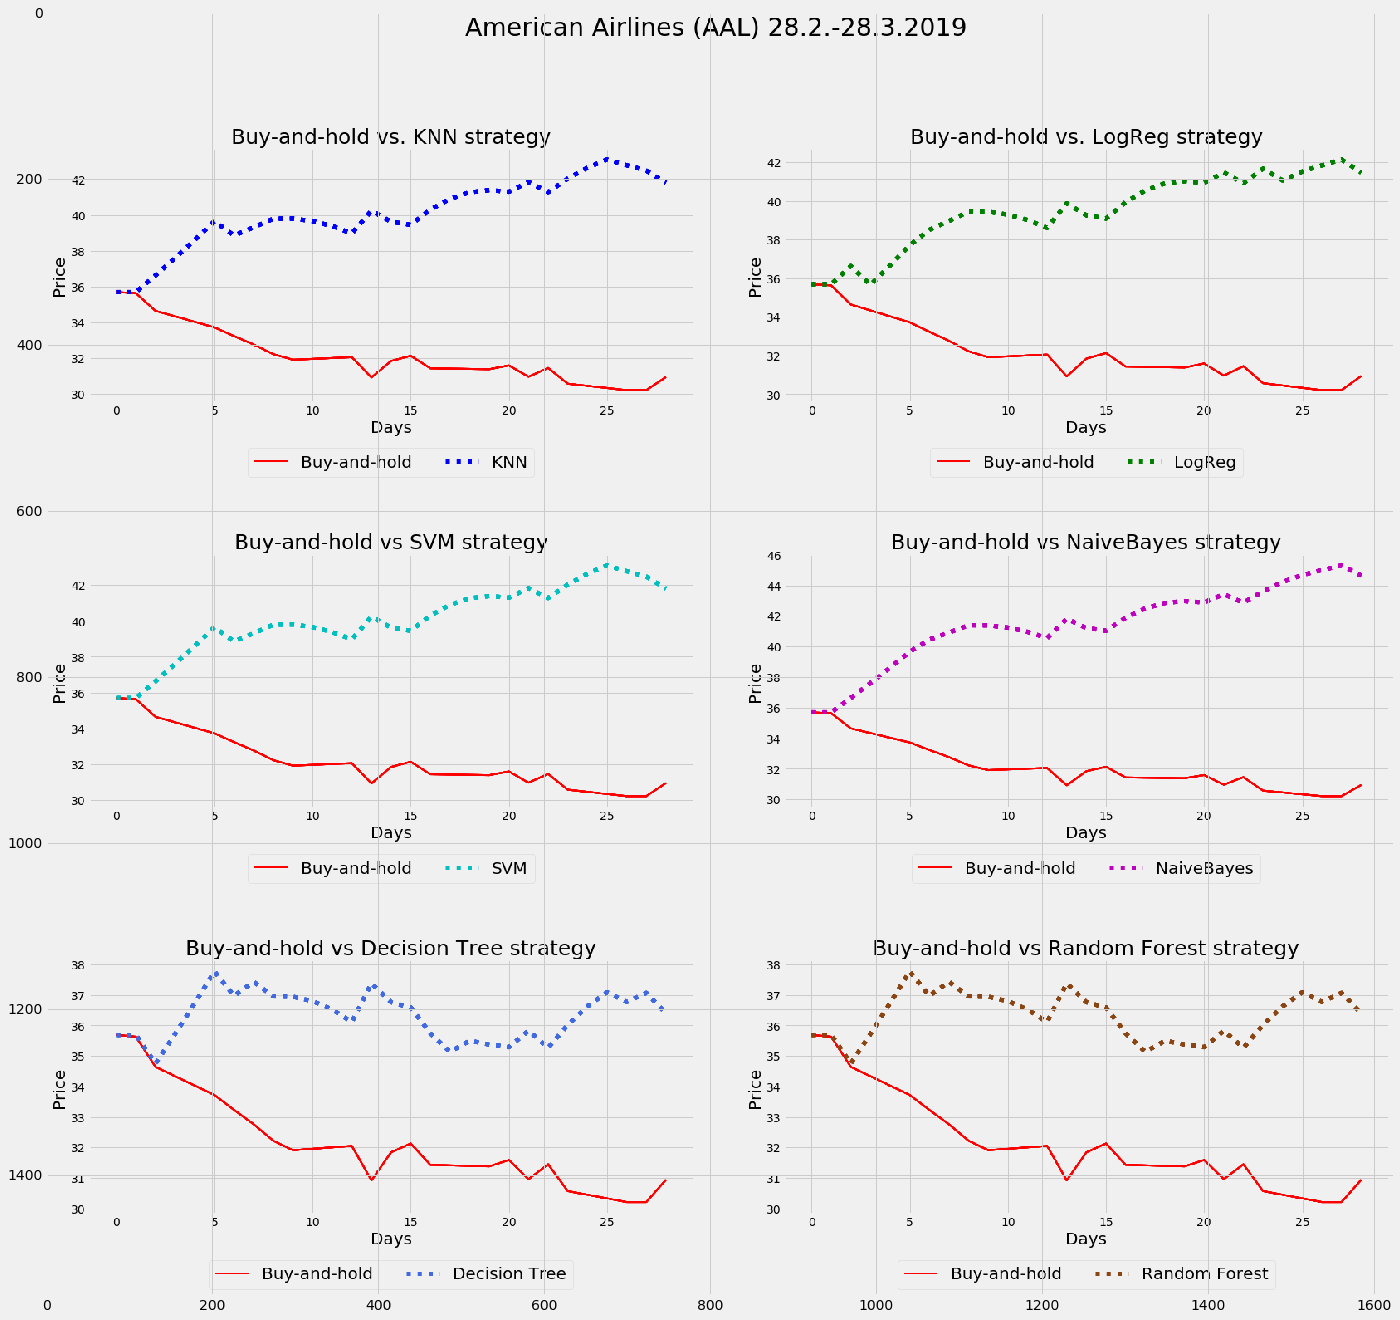

In [189]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 25, 22 
plt.suptitle('American Airlines', fontsize=30)

ax1 = complete_df['Adj_Close_stock']
ax2 = complete_df['KNN_Result']
ax3 = complete_df['LogReg_Result']
ax4 = complete_df['SVM_Result']
ax5 = complete_df['Naive_Bayes_Result']
ax6 = complete_df['Decision_Tree_Result']
ax7 = complete_df['Random_Forest_Result']

for i in range (1, 7):
    plt.subplots_adjust(hspace=0.6, wspace=0.15)
        
    plt.subplot(3,2,1)
    plt.plot(ax1, 'r',  linewidth=2)
    plt.plot(ax2,  'b',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Buy-and-hold vs. KNN strategy', fontsize=25)
    a='Buy-and-hold'
    b='KNN'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,2)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax3, 'g',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Buy-and-hold vs. LogReg strategy', fontsize=25)
    a='Buy-and-hold'
    b='LogReg'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,3)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax4, 'c',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Buy-and-hold vs SVM strategy', fontsize=25)
    a='Buy-and-hold'
    b='SVM'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,4)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax5, 'm',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Buy-and-hold vs NaiveBayes strategy', fontsize=25)
    a='Buy-and-hold'
    b='NaiveBayes'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,5)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax6, 'royalblue',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Buy-and-hold vs Decision Tree strategy', fontsize=25)
    a='Buy-and-hold'
    b='Decision Tree'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
    
    plt.subplot(3,2,6)
    plt.plot(ax1, 'r',  linewidth=2 )
    plt.plot(ax7, 'saddlebrown',  linestyle=':', linewidth=5)
    plt.xlabel('Days', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.title('Buy-and-hold vs Random Forest strategy', fontsize=25)
    a='Buy-and-hold'
    b='Random Forest'
    plt.legend((a,b), fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)


plt.show()